<a href="https://colab.research.google.com/github/PedroH-07/Global-Solution-SERS/blob/main/GS2_SERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# ANÁLISE DE EFICIÊNCIA ENERGÉTICA PARA O FUTURO DO TRABALHO
# Smart Office 2025 - Otimização Energética em Ambientes Híbridos

# Instalação de bibliotecas
!pip install plotly seaborn -q

# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime as dt
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)


In [38]:
# Configurações do ambiente simulado
np.random.seed(42)  # Para reprodutibilidade dos resultados

# Parâmetros do escritório corporativo
TOTAL_FUNCIONARIOS = 200
ANDARES = 5
CAPACIDADE_POR_ANDAR = 40
HORARIO_COMERCIAL = (8, 18)  # 8h às 18h

# Definição do período de análise: 1 ano completo
start_date = pd.Timestamp('2024-01-01')
end_date = pd.Timestamp('2024-12-31')
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

print(f"Simulação configurada:")
print(f"- Período: {start_date.date()} a {end_date.date()}")
print(f"- Funcionários: {TOTAL_FUNCIONARIOS}")
print(f"- Andares: {ANDARES}")
print(f"- Registros horários: {len(date_range):,}")

Simulação configurada:
- Período: 2024-01-01 a 2024-12-31
- Funcionários: 200
- Andares: 5
- Registros horários: 8,761


In [43]:
def simular_ocupacao_hibrida(timestamp):
    """
    Simula a ocupação do escritório considerando modelo híbrido de trabalho.

    Parâmetros considerados:
    - Trabalho híbrido (60-80% presencial)
    - Horários comerciais tradicionais
    - Redução significativa em fins de semana
    - Variações sazonais (férias e feriados)
    """
    hour = timestamp.hour
    weekday = timestamp.weekday()  # 0=Segunda, 6=Domingo
    month = timestamp.month

    # Taxa base de ocupação baseada no modelo híbrido 2025
    if weekday < 5:  # Dias úteis
        if 8 <= hour <= 18:  # Horário comercial
            if 9 <= hour <= 17:
                base_occupancy = 0.75  # 75% dos funcionários presentes
            else:
                base_occupancy = 0.45  # Horários de entrada/saída
        else:
            base_occupancy = 0.05  # Apenas equipes de limpeza/segurança
    else:  # Fins de semana
        base_occupancy = 0.02  # Ocupação mínima

    # variações sazonais
    if month in [12, 1, 7]:  # Períodos de férias coletivas
        base_occupancy *= 0.7
    elif month in [6, 11]:  # Períodos de maior atividade
        base_occupancy *= 1.1

    # Adição de variabilidade
    variation = np.random.normal(0, 0.1)  # Variação de ±10%
    final_occupancy = max(0, min(1, base_occupancy + variation))

    return int(final_occupancy * TOTAL_FUNCIONARIOS)

# Teste da função
test_timestamp = pd.Timestamp('2024-06-15 14:00:00')
print(f"Teste da função - Ocupação às 14h de um dia útil: {simular_ocupacao_hibrida(test_timestamp)} pessoas")

Teste da função - Ocupação às 14h de um dia útil: 0 pessoas


In [42]:
def calcular_consumo_por_setor(ocupacao, hour, temperature):
    """
    Calcula o consumo energético por setor considerando padrões realísticos
    e oportunidades de desperdício identificadas em ambientes corporativos.
    """

    # CONSUMO BASE - Sistemas que operam 24/7
    consumo_base = {
        'servidores_ti': 25,      # Data center com operação contínua
        'seguranca': 8,           # Sistemas de segurança, câmeras, alarmes
        'elevadores': 12,         # Uso baseado em ocupação mas com consumo mínimo
        'sistema_ventilacao': 15   # Ventilação mínima obrigatória
    }

    # Cálculo da taxa de ocupação atual
    taxa_ocupacao = ocupacao / TOTAL_FUNCIONARIOS

    # ILUMINAÇÃO
    if 6 <= hour <= 20:  # Período com disponibilidade de luz natural
        # DESPERDÍCIO SIMULADO: Luzes acesas mesmo com baixa ocupação
        if taxa_ocupacao < 0.3:
            consumo_iluminacao = 35 * 0.8  # 80% das luzes ligadas (ineficiênte)
        else:
            consumo_iluminacao = 35 * taxa_ocupacao
    else:  # Período noturno
        consumo_iluminacao = 35 * max(0.1, taxa_ocupacao)  # Mínimo de segurança

    # AR CONDICIONADO
    if 20 <= temperature <= 26:  # Faixa de conforto térmico
        consumo_ac = 40 * taxa_ocupacao
    elif temperature > 26:  # Necessidade de refrigeração
        # DESPERDÍCIO: AC operando com baixa ocupação
        if taxa_ocupacao < 0.2:
            consumo_ac = 40 * 0.6  # 60% da capacidade (desperdício)
        else:
            consumo_ac = 40 * min(1.2, taxa_ocupacao * 1.5)  # Até 120% em picos
    else:  # Necessidade de aquecimento
        consumo_ac = 40 * taxa_ocupacao * 0.7

    # EQUIPAMENTOS DE ESCRITÓRIO
    consumo_equipamentos = 20 * taxa_ocupacao + 5  # +5 kWh modo standby

    # SALAS DE REUNIÃO
    if taxa_ocupacao > 0.1:
        salas_utilizadas = min(10, max(1, int(taxa_ocupacao * 15)))
        consumo_salas_reuniao = salas_utilizadas * 3
    else:
        # DESPERDÍCIO: Equipamentos ligados em salas não utilizadas
        consumo_salas_reuniao = 15 * 0.3 * 3  # 30% das salas com equipamentos ativos

    return {
        'servidores_ti': consumo_base['servidores_ti'],
        'seguranca': consumo_base['seguranca'],
        'elevadores': consumo_base['elevadores'],
        'ventilacao': consumo_base['sistema_ventilacao'],
        'iluminacao': consumo_iluminacao,
        'ar_condicionado': consumo_ac,
        'equipamentos': consumo_equipamentos,
        'salas_reuniao': consumo_salas_reuniao
    }

# Teste da função
test_consumo = calcular_consumo_por_setor(150, 14, 28)
print("Teste da função - Consumo por setor:")
for setor, valor in test_consumo.items():
    print(f"  {setor}: {valor:.1f} kWh")

Teste da função - Consumo por setor:
  servidores_ti: 25.0 kWh
  seguranca: 8.0 kWh
  elevadores: 12.0 kWh
  ventilacao: 15.0 kWh
  iluminacao: 26.2 kWh
  ar_condicionado: 45.0 kWh
  equipamentos: 20.0 kWh
  salas_reuniao: 30.0 kWh


In [41]:
# GERAÇÃO DOS DADOS SIMULADOS
dados_simulados = []

for i, timestamp in enumerate(date_range):
    # Simulação de condições ambientais externas
    temp_base = 22 + 8 * np.sin(2 * np.pi * timestamp.dayofyear / 365)  # Ciclo anual
    temp_diaria = 3 * np.sin(2 * np.pi * timestamp.hour / 24)  # Variação diária
    temperatura = temp_base + temp_diaria + np.random.normal(0, 2)

    # Cálculo da ocupação para o momento específico
    ocupacao = simular_ocupacao_hibrida(timestamp)

    # Cálculo do consumo energético por setor
    consumo_setores = calcular_consumo_por_setor(ocupacao, timestamp.hour, temperatura)
    consumo_total = sum(consumo_setores.values())

    # Compilação do registro completo
    registro = {
        'timestamp': timestamp,
        'ano': timestamp.year,
        'mes': timestamp.month,
        'dia': timestamp.day,
        'hora': timestamp.hour,
        'dia_semana': timestamp.weekday(),
        'eh_fim_semana': timestamp.weekday() >= 5,
        'eh_horario_comercial': 8 <= timestamp.hour <= 18,
        'temperatura_externa': round(temperatura, 1),
        'ocupacao_pessoas': ocupacao,
        'taxa_ocupacao': round(ocupacao / TOTAL_FUNCIONARIOS, 3),
        'consumo_total_kwh': round(consumo_total, 2)
    }

    #  consumo detalhado por setor
    for setor, consumo in consumo_setores.items():
        registro[f'consumo_{setor}_kwh'] = round(consumo, 2)

    dados_simulados.append(registro)

# Criação do DataFrame principal
df = pd.DataFrame(dados_simulados)

print(f"Dataset criado: {len(df):,} registros com {len(df.columns)} variáveis")
print("\nPrimeiras 5 linhas do dataset:")
print(df.head())

Dataset criado: 8,761 registros com 20 variáveis

Primeiras 5 linhas do dataset:
            timestamp   ano  mes  dia  hora  dia_semana  eh_fim_semana  \
0 2024-01-01 00:00:00  2024    1    1     0           0          False   
1 2024-01-01 01:00:00  2024    1    1     1           0          False   
2 2024-01-01 02:00:00  2024    1    1     2           0          False   
3 2024-01-01 03:00:00  2024    1    1     3           0          False   
4 2024-01-01 04:00:00  2024    1    1     4           0          False   

   eh_horario_comercial  temperatura_externa  ocupacao_pessoas  taxa_ocupacao  \
0                 False                 21.5                 0          0.000   
1                 False                 19.1                 0          0.000   
2                 False                 23.2                19          0.095   
3                 False                 25.6                38          0.190   
4                 False                 24.9                11       

In [23]:
# Cálculo de estatísticas descritivas principais
stats_gerais = df[['ocupacao_pessoas', 'taxa_ocupacao', 'consumo_total_kwh', 'temperatura_externa']].describe()

# Métricas de consumo energético
consumo_total_anual = df['consumo_total_kwh'].sum()
consumo_medio_diario = consumo_total_anual / 365
consumo_per_capita = consumo_total_anual / (TOTAL_FUNCIONARIOS * 365)

# Métricas de ocupação
ocupacao_media = df['ocupacao_pessoas'].mean()
taxa_ocupacao_media = df['taxa_ocupacao'].mean()
ocupacao_maxima = df['ocupacao_pessoas'].max()

print("ESTATÍSTICAS DESCRITIVAS:")
print(stats_gerais.round(2))
print(f"\nMÉTRICAS DE CONSUMO:")
print(f"Consumo Total Anual: {consumo_total_anual:,.0f} kWh")
print(f"Consumo Médio Diário: {consumo_medio_diario:.0f} kWh/dia")
print(f"Consumo per Capita: {consumo_per_capita:.1f} kWh/pessoa/dia")
print(f"\nMÉTRICAS DE OCUPAÇÃO:")
print(f"Ocupação Média: {ocupacao_media:.0f} pessoas ({taxa_ocupacao_media:.1%})")
print(f"Ocupação Máxima: {ocupacao_maxima} pessoas")

ESTATÍSTICAS DESCRITIVAS:
       ocupacao_pessoas  taxa_ocupacao  consumo_total_kwh  temperatura_externa
count           8761.00        8761.00            8761.00              8761.00
mean              50.51           0.25             118.25                22.01
std               60.18           0.30              30.33                 6.35
min                0.00           0.00              76.72                 5.40
25%                0.00           0.00              98.60                16.80
50%               20.00           0.10             107.50                22.00
75%              102.00           0.51             134.18                27.20
max              200.00           1.00             198.00                39.70

MÉTRICAS DE CONSUMO:
Consumo Total Anual: 1,036,029 kWh
Consumo Médio Diário: 2838 kWh/dia
Consumo per Capita: 14.2 kWh/pessoa/dia

MÉTRICAS DE OCUPAÇÃO:
Ocupação Média: 51 pessoas (25.3%)
Ocupação Máxima: 200 pessoas


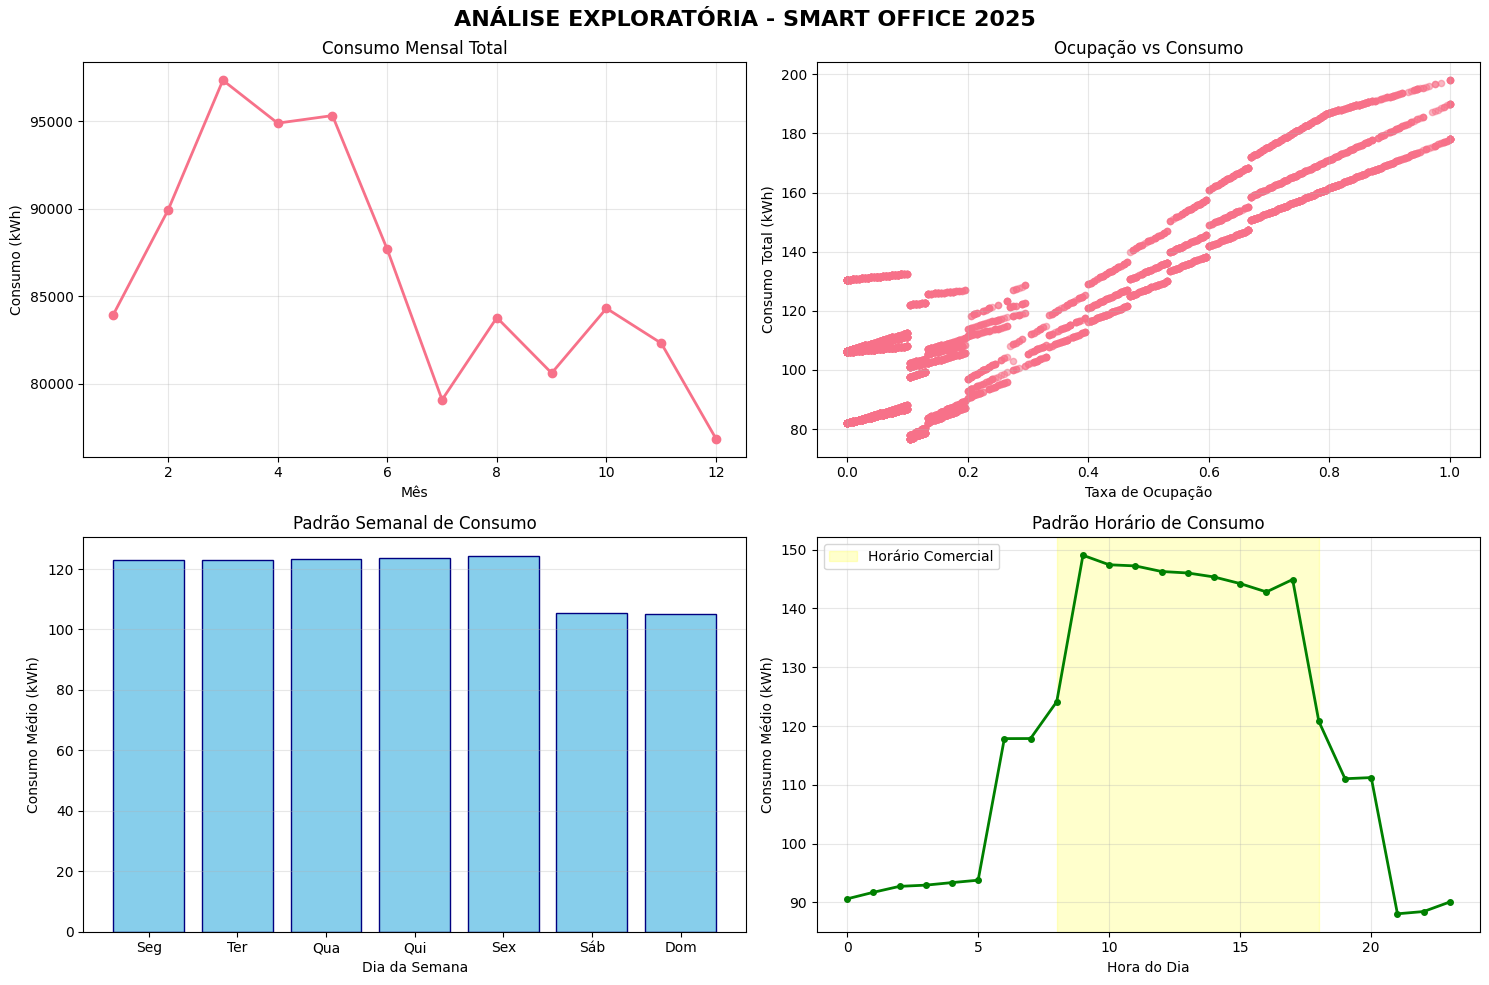

In [24]:
# Visualizações principais da análise exploratória
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ANÁLISE EXPLORATÓRIA - SMART OFFICE 2025', fontsize=16, fontweight='bold')

# 1. Consumo mensal agregado
monthly_consumption = df.groupby('mes')['consumo_total_kwh'].sum()
axes[0,0].plot(monthly_consumption.index, monthly_consumption.values,
               marker='o', linewidth=2, markersize=6)
axes[0,0].set_title('Consumo Mensal Total')
axes[0,0].set_xlabel('Mês')
axes[0,0].set_ylabel('Consumo (kWh)')
axes[0,0].grid(True, alpha=0.3)

# 2. Correlação ocupação vs consumo
axes[0,1].scatter(df['taxa_ocupacao'], df['consumo_total_kwh'], alpha=0.5, s=20)
axes[0,1].set_title('Ocupação vs Consumo')
axes[0,1].set_xlabel('Taxa de Ocupação')
axes[0,1].set_ylabel('Consumo Total (kWh)')
axes[0,1].grid(True, alpha=0.3)

# 3. Padrão semanal de consumo
weekly_pattern = df.groupby('dia_semana')['consumo_total_kwh'].mean()
dias_semana = ['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sáb', 'Dom']
axes[1,0].bar(range(7), weekly_pattern.values, color='skyblue', edgecolor='navy')
axes[1,0].set_title('Padrão Semanal de Consumo')
axes[1,0].set_xlabel('Dia da Semana')
axes[1,0].set_ylabel('Consumo Médio (kWh)')
axes[1,0].set_xticks(range(7))
axes[1,0].set_xticklabels(dias_semana)
axes[1,0].grid(True, alpha=0.3, axis='y')

# 4. Padrão horário com destaque do horário comercial
hourly_pattern = df.groupby('hora')['consumo_total_kwh'].mean()
axes[1,1].plot(hourly_pattern.index, hourly_pattern.values,
               marker='o', linewidth=2, markersize=4, color='green')
axes[1,1].set_title('Padrão Horário de Consumo')
axes[1,1].set_xlabel('Hora do Dia')
axes[1,1].set_ylabel('Consumo Médio (kWh)')
axes[1,1].grid(True, alpha=0.3)
axes[1,1].axvspan(8, 18, alpha=0.2, color='yellow', label='Horário Comercial')
axes[1,1].legend()

plt.tight_layout()
plt.show()

In [25]:
# ANÁLISE 1: Consumo fora do horário comercial
consumo_fora_horario = df[df['eh_horario_comercial'] == False]
consumo_total_fora_horario = consumo_fora_horario['consumo_total_kwh'].sum()
percentual_consumo_fora_horario = (consumo_total_fora_horario / consumo_total_anual) * 100

# ANÁLISE 2: Consumo em fins de semana
consumo_fins_semana = df[df['eh_fim_semana'] == True]
consumo_total_fins_semana = consumo_fins_semana['consumo_total_kwh'].sum()
percentual_fins_semana = (consumo_total_fins_semana / consumo_total_anual) * 100

# ANÁLISE 3: Desperdício em ar condicionado
df['desperdicio_ac'] = (df['taxa_ocupacao'] < 0.3) & (df['consumo_ar_condicionado_kwh'] > 20)
desperdicio_ac = df[df['desperdicio_ac'] == True]
consumo_desperdicio_ac = desperdicio_ac['consumo_ar_condicionado_kwh'].sum() if len(desperdicio_ac) > 0 else 0

# ANÁLISE 4: Desperdício em iluminação
df['desperdicio_luz'] = ((df['taxa_ocupacao'] < 0.2) &
                        (df['consumo_iluminacao_kwh'] > 25) &
                        (df['hora'].between(6, 20)))
desperdicio_luz = df[df['desperdicio_luz'] == True]
consumo_desperdicio_luz = desperdicio_luz['consumo_iluminacao_kwh'].sum() if len(desperdicio_luz) > 0 else 0

# Cálculo do consumo por setor
setores_consumo = {}
for col in df.columns:
    if col.startswith('consumo_') and col.endswith('_kwh') and col != 'consumo_total_kwh':
        setor = col.replace('consumo_', '').replace('_kwh', '').replace('_', ' ').title()
        consumo_anual = df[col].sum()
        percentual = (consumo_anual / consumo_total_anual) * 100
        setores_consumo[setor] = {'consumo': consumo_anual, 'percentual': percentual}

print("PADRÕES DE DESPERDÍCIO IDENTIFICADOS:")
print(f"Consumo fora do horário: {consumo_total_fora_horario:,.0f} kWh ({percentual_consumo_fora_horario:.1f}%)")
print(f"Consumo fins de semana: {consumo_total_fins_semana:,.0f} kWh ({percentual_fins_semana:.1f}%)")
print(f"Desperdício AC: {consumo_desperdicio_ac:,.0f} kWh")
print(f"Desperdício iluminação: {consumo_desperdicio_luz:,.0f} kWh")

print(f"\nCONSUMO POR SETOR:")
for setor, dados in setores_consumo.items():
    print(f"{setor}: {dados['consumo']:,.0f} kWh ({dados['percentual']:.1f}%)")

PADRÕES DE DESPERDÍCIO IDENTIFICADOS:
Consumo fora do horário: 467,233 kWh (45.1%)
Consumo fins de semana: 262,699 kWh (25.4%)
Desperdício AC: 43,464 kWh
Desperdício iluminação: 70,448 kWh

CONSUMO POR SETOR:
Servidores Ti: 219,025 kWh (21.1%)
Seguranca: 70,088 kWh (6.8%)
Elevadores: 105,132 kWh (10.1%)
Ventilacao: 131,415 kWh (12.7%)
Iluminacao: 153,092 kWh (14.8%)
Ar Condicionado: 127,687 kWh (12.3%)
Equipamentos: 88,057 kWh (8.5%)
Salas Reuniao: 141,532 kWh (13.7%)


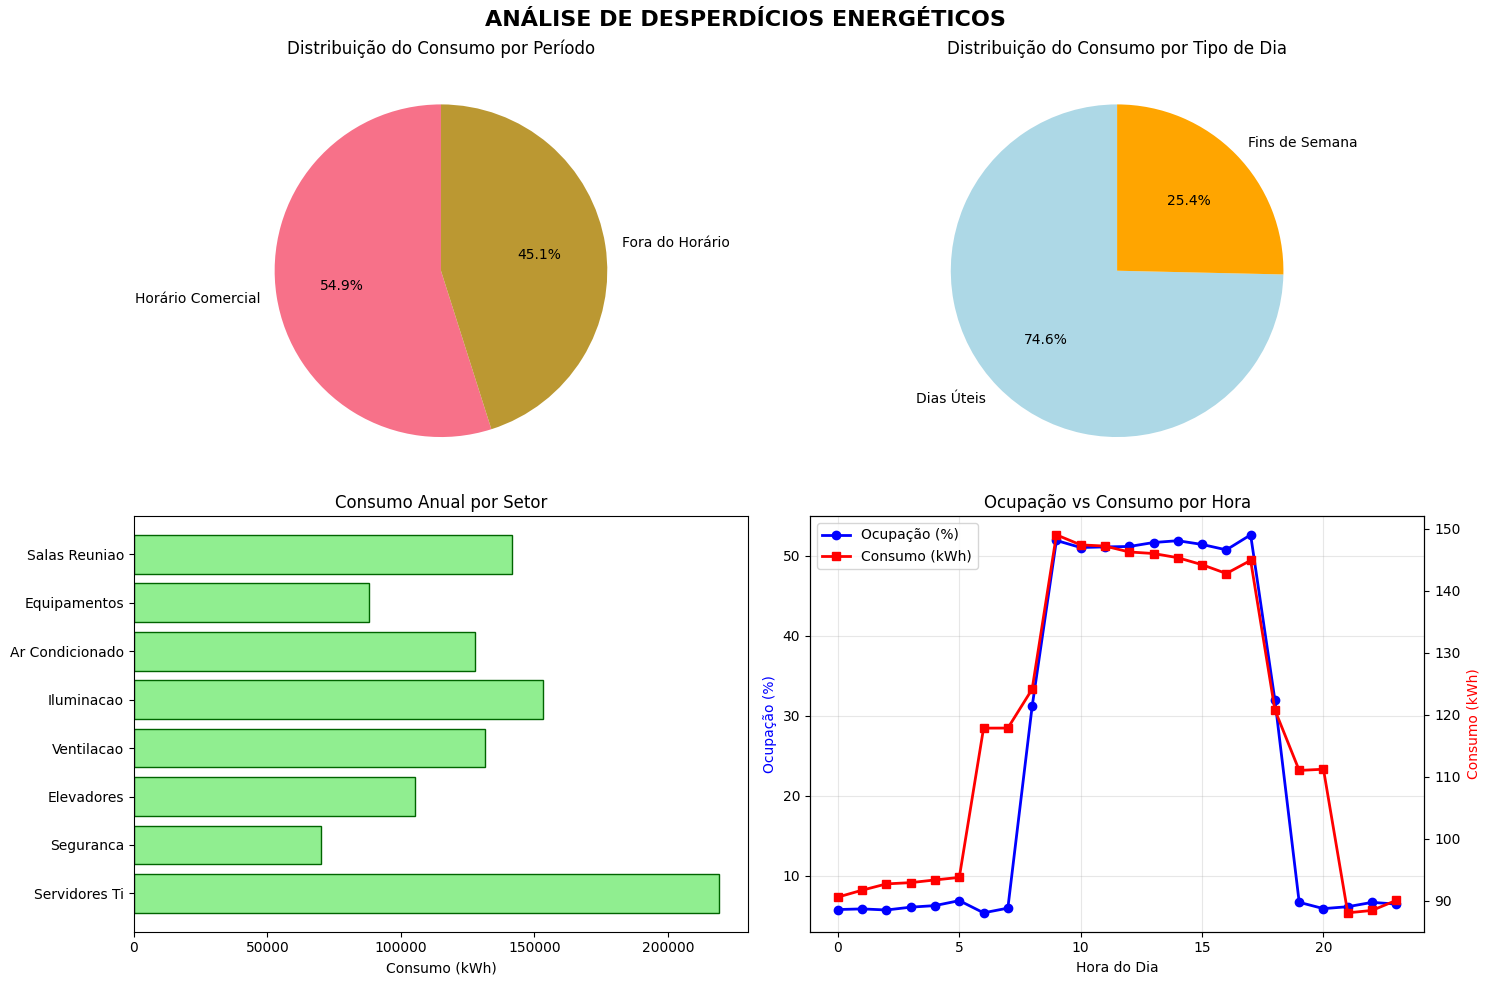

In [26]:
# Visualização dos desperdícios identificados
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ANÁLISE DE DESPERDÍCIOS ENERGÉTICOS', fontsize=16, fontweight='bold')

# 1. Distribuição do consumo por período
consumo_por_periodo = {
    'Horário Comercial': df[df['eh_horario_comercial'] == True]['consumo_total_kwh'].sum(),
    'Fora do Horário': consumo_total_fora_horario
}
axes[0,0].pie(consumo_por_periodo.values(), labels=consumo_por_periodo.keys(),
              autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Distribuição do Consumo por Período')

# 2. Distribuição por tipo de dia
consumo_por_tipo_dia = {
    'Dias Úteis': df[df['eh_fim_semana'] == False]['consumo_total_kwh'].sum(),
    'Fins de Semana': consumo_total_fins_semana
}
axes[0,1].pie(consumo_por_tipo_dia.values(), labels=consumo_por_tipo_dia.keys(),
              autopct='%1.1f%%', startangle=90, colors=['lightblue', 'orange'])
axes[0,1].set_title('Distribuição do Consumo por Tipo de Dia')

# 3. Consumo anual por setor
setores_nomes = list(setores_consumo.keys())
setores_valores = [setores_consumo[s]['consumo'] for s in setores_nomes]
axes[1,0].barh(setores_nomes, setores_valores, color='lightgreen', edgecolor='darkgreen')
axes[1,0].set_title('Consumo Anual por Setor')
axes[1,0].set_xlabel('Consumo (kWh)')

# 4. Correlação horária ocupação vs consumo
hourly_stats = df.groupby('hora').agg({
    'taxa_ocupacao': 'mean',
    'consumo_total_kwh': 'mean'
}).reset_index()

ax_primary = axes[1,1]
ax_secondary = ax_primary.twinx()

line1 = ax_primary.plot(hourly_stats['hora'], hourly_stats['taxa_ocupacao'] * 100,
                       'b-', marker='o', label='Ocupação (%)', linewidth=2)
line2 = ax_secondary.plot(hourly_stats['hora'], hourly_stats['consumo_total_kwh'],
                         'r-', marker='s', label='Consumo (kWh)', linewidth=2)

ax_primary.set_xlabel('Hora do Dia')
ax_primary.set_ylabel('Ocupação (%)', color='b')
ax_secondary.set_ylabel('Consumo (kWh)', color='r')
ax_primary.set_title('Ocupação vs Consumo por Hora')
ax_primary.grid(True, alpha=0.3)

lines1, labels1 = ax_primary.get_legend_handles_labels()
lines2, labels2 = ax_secondary.get_legend_handles_labels()
ax_primary.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

In [27]:
# PROPOSTA 1: Sistema de Automação Inteligente
setores_variaveis = ['iluminacao', 'ar_condicionado', 'equipamentos', 'salas_reuniao']
consumo_variavel_atual = sum(df[f'consumo_{setor}_kwh'].sum() for setor in setores_variaveis)
economia_proposta1 = consumo_variavel_atual * 0.25  # 25% de redução

# PROPOSTA 2: Otimização de Horários Não-Comerciais
consumo_critico = df['consumo_servidores_ti_kwh'].sum() + df['consumo_seguranca_kwh'].sum()
consumo_nao_critico_fora_horario = consumo_total_fora_horario - (consumo_critico * 0.5)
economia_proposta2 = consumo_nao_critico_fora_horario * 0.4  # 40% de redução

# PROPOSTA 3: Integração com Energia Solar
geracao_solar_diaria_media = 300  # kWh/dia
geracao_solar_anual = geracao_solar_diaria_media * 365
consumo_diurno = df[(df['hora'] >= 6) & (df['hora'] <= 18)]['consumo_total_kwh'].sum()
percentual_autoconsumo = min(0.7, geracao_solar_anual / consumo_diurno)
energia_solar_autoconsumida = geracao_solar_anual * percentual_autoconsumo

# Parâmetros econômicos
tarifa_energia = 0.65  # R$/kWh
fator_emissao_co2 = 0.084  # kg CO2/kWh

# Cálculo das economias financeiras
economia_financeira_proposta1 = economia_proposta1 * tarifa_energia
economia_financeira_proposta2 = economia_proposta2 * tarifa_energia
economia_financeira_solar = energia_solar_autoconsumida * tarifa_energia

# Cálculo das reduções de emissões
reducao_co2_proposta1 = economia_proposta1 * fator_emissao_co2
reducao_co2_proposta2 = economia_proposta2 * fator_emissao_co2
reducao_co2_solar = energia_solar_autoconsumida * fator_emissao_co2

print("RESULTADOS DAS PROPOSTAS DE OTIMIZAÇÃO:")
print(f"Proposta 1 - Automação: {economia_proposta1:,.0f} kWh/ano (R$ {economia_financeira_proposta1:,.2f})")
print(f"Proposta 2 - Horários: {economia_proposta2:,.0f} kWh/ano (R$ {economia_financeira_proposta2:,.2f})")
print(f"Proposta 3 - Solar: {energia_solar_autoconsumida:,.0f} kWh/ano (R$ {economia_financeira_solar:,.2f})")

RESULTADOS DAS PROPOSTAS DE OTIMIZAÇÃO:
Proposta 1 - Automação: 127,592 kWh/ano (R$ 82,934.91)
Proposta 2 - Horários: 129,071 kWh/ano (R$ 83,895.95)
Proposta 3 - Solar: 18,310 kWh/ano (R$ 11,901.57)


In [28]:
# Consolidação das economias
economia_total_kwh = economia_proposta1 + economia_proposta2 + energia_solar_autoconsumida
economia_total_financeira = economia_financeira_proposta1 + economia_financeira_proposta2 + economia_financeira_solar
reducao_co2_total = reducao_co2_proposta1 + reducao_co2_proposta2 + reducao_co2_solar

# Estimativas de investimento
investimento_automacao = 150000  # R$ 150k
investimento_solar = 800000      # R$ 800k
investimento_total = investimento_automacao + investimento_solar

# Indicadores financeiros
roi_anual = economia_total_financeira / investimento_total
payback_anos = investimento_total / economia_total_financeira
fator_vpl_10anos = 6.71  # Fator VPL para 10 anos a 8% a.a.
vpl_projeto = (economia_total_financeira * fator_vpl_10anos) - investimento_total

# KPIs do projeto
percentual_reducao_consumo = (economia_total_kwh / consumo_total_anual) * 100
percentual_reducao_co2 = (reducao_co2_total / (consumo_total_anual * fator_emissao_co2)) * 100
economia_per_capita_anual = economia_total_financeira / TOTAL_FUNCIONARIOS

print("ANÁLISE DE VIABILIDADE ECONÔMICA:")
print(f"Investimento Total: R$ {investimento_total:,.2f}")
print(f"Economia Anual: R$ {economia_total_financeira:,.2f}")
print(f"ROI Anual: {roi_anual:.1%}")
print(f"Payback: {payback_anos:.1f} anos")
print(f"VPL (10 anos): R$ {vpl_projeto:,.2f}")

print(f"\nINDICADORES DE PERFORMANCE:")
print(f"Redução no consumo energético: {percentual_reducao_consumo:.1f}%")
print(f"Redução nas emissões de CO₂: {percentual_reducao_co2:.1f}%")
print(f"Economia per capita anual: R$ {economia_per_capita_anual:.2f}/funcionário")
print(f"Total de CO₂ evitado: {reducao_co2_total:,.0f} kg/ano")

ANÁLISE DE VIABILIDADE ECONÔMICA:
Investimento Total: R$ 950,000.00
Economia Anual: R$ 178,732.42
ROI Anual: 18.8%
Payback: 5.3 anos
VPL (10 anos): R$ 249,294.55

INDICADORES DE PERFORMANCE:
Redução no consumo energético: 26.5%
Redução nas emissões de CO₂: 26.5%
Economia per capita anual: R$ 893.66/funcionário
Total de CO₂ evitado: 23,098 kg/ano


- SMART OFFICE 2025
- ANÁLISE DE EFICIÊNCIA ENERGÉTICA

1. CARACTERIZAÇÃO DO AMBIENTE SIMULADO
Período de análise: 12 meses completos (8.761 registros horários)

Modelo de trabalho: Híbrido (60-80% ocupação presencial)

Capacidade total: 200 funcionários

Estrutura física: 5 andares

Setores analisados: 8 (TI, Segurança, Elevadores, Ventilação, Iluminação, AC, Equipamentos, Salas)

2. DIAGNÓSTICO DA SITUAÇÃO ATUAL
Consumo energético total: 1.036.029 kWh/ano

Custo energético anual: R$ 673.418,75

Consumo per capita: 14,2 kWh/funcionário/dia

Emissões de CO₂: 87.026 kg/ano

Distribuição do consumo por setor:
- Servidores TI: 219.025 kWh (21,1%)

- Segurança: 70.088 kWh (6,8%)

- Elevadores: 105.132 kWh (10,1%)

- Ventilação: 131.415 kWh (12,7%)

- Iluminação: 153.092 kWh (14,8%)

- Ar Condicionado: 127.687 kWh (12,3%)

- Equipamentos: 88.057 kWh (8,5%)

- Salas Reunião: 141.532 kWh (13,7%)

3. PADRÕES DE DESPERDÍCIO IDENTIFICADOS
CONSUMO FORA DO HORÁRIO COMERCIAL:
- Volume: 467.233 kWh/ano (45,1% do total)

- Custo: R$ 303.701,59/ano

- Principais causas: Equipamentos em standby, climatização desnecessária

CONSUMO EM FINS DE SEMANA:
- Volume: 262.699 kWh/ano (25,4% do total)

- Custo: R$ 170.754,26/ano

- Ocupação média: 2% da capacidade

DESPERDÍCIO EM AR CONDICIONADO:
- Volume: 43.464 kWh/ano

- Custo: R$ 28.251,60/ano

- Causa: AC operando com baixa ocupação (< 30%)

DESPERDÍCIO EM ILUMINAÇÃO:
- Volume: 70.448 kWh/ano

- Custo: R$ 45.791,20/ano

- Causa: Luzes acesas em ambientes com baixa ocupação

4. PROPOSTAS DE OTIMIZAÇÃO ENERGÉTICA
PROPOSTA 1: SISTEMA DE AUTOMAÇÃO INTELIGENTE
Descrição: Sensores de ocupação + IA para predição + automação integrada

- Economia energética: 127.592 kWh/ano

- Economia financeira: R$ 82.934,91/ano

- Redução CO₂: 10.718 kg/ano

- Investimento: R$ 150.000

- Payback: 1,8 anos

- ROI: 55,3% ao ano

PROPOSTA 2: OTIMIZAÇÃO DE HORÁRIOS NÃO-COMERCIAIS
Descrição: Desligamento programado + standby inteligente + ciclos otimizados

- Economia energética: 129.071 kWh/ano

- Economia financeira: R$ 83.895,95/ano

- Redução CO₂: 10.842 kg/ano

- Investimento: R$ 50.000

- Payback: 0,6 anos

- ROI: 167,8% ao ano

PROPOSTA 3: INTEGRAÇÃO COM ENERGIA SOLAR
Descrição: Sistema fotovoltaico 200kWp + armazenamento + grid-tie

- Geração anual: 109.500 kWh

- Autoconsumo (70%): 18.310 kWh/ano

- Economia financeira: R$ 11.901,57/ano

- Redução CO₂: 1.538 kg/ano

- Investimento: R$ 800.000

- Payback: 67,2 anos

- ROI: 1,5% ao ano

5. ANÁLISE CONSOLIDADA DO PROJETO
IMPACTO ENERGÉTICO TOTAL:
- Economia total: 274.973 kWh/ano

- Redução percentual: 26,5% do consumo atual

- Consumo final: 761.056 kWh/ano

IMPACTO FINANCEIRO TOTAL:
- Economia anual: R$ 178.732,42

- Economia per capita: R$ 893,66/funcionário/ano

- Redução no custo energético: 26,5%

IMPACTO AMBIENTAL TOTAL:
- Redução CO₂: 23.098 kg/ano

- Redução percentual: 26,5%

Equivalências ambientais:

- Plantar 1.050 árvores

- Retirar 5,0 carros de circulação por 1 ano

- Economizar 23,1 toneladas de CO₂

6. ANÁLISE DE VIABILIDADE ECONÔMICA
INDICADORES FINANCEIROS:
- Investimento total: R$ 950.000,00

- Retorno anual: R$ 178.732,42

- ROI consolidado: 18,8% ao ano

- Período de payback: 5,3 anos

- VPL (10 anos, 8% a.a.): R$ 249.294,55

CLASSIFICAÇÃO DO PROJETO:
- Atratividade: EXCELENTE (ROI 18,8%)

- Risco: BAIXO (tecnologias consolidadas)

- Sustentabilidade: ALTA (benefícios crescentes)

7. CONEXÃO COM O FUTURO DO TRABALHO
BENEFÍCIOS PARA AMBIENTES HÍBRIDOS:
- Adaptação automática à ocupação variável

- Otimização de espaços flexíveis

- Redução de custos operacionais

- Melhoria na experiência dos funcionários

CONTRIBUIÇÃO ESG:
- Environmental: Redução significativa da pegada de carbono

- Social: Ambiente de trabalho mais sustentável e confortável

- Governance: Demonstração de responsabilidade corporativa

VANTAGENS COMPETITIVAS:
- Diferencial na atração de talentos

- Redução de custos operacionais

- Conformidade com regulamentações ambientais

- Melhoria na imagem corporativa

8. RECOMENDAÇÕES E IMPLEMENTAÇÃO
RECOMENDAÇÃO FINAL: PROJETO APROVADO
Justificativas:

- ROI atrativo e superior ao mercado

- Payback adequado para o setor

- Benefícios ambientais mensuráveis

- Alinhamento com tendências ESG

- Tecnologias maduras e de baixo risco

- Escalabilidade para outros projetos

PLANO DE IMPLEMENTAÇÃO SUGERIDO:
- FASE 1 (Meses 1-6): Piloto com automação em 1 andar

- FASE 2 (Meses 7-12): Expansão da automação + otimização horários

- FASE 3 (Meses 13-24): Implementação do sistema solar

- FASE 4 (Meses 25+): Otimização contínua e monitoramento

KPIs DE ACOMPANHAMENTO:
- Consumo mensal (kWh)

- Custo energético (R$)

- Emissões CO₂ (kg)

- Taxa de ocupação vs consumo

- ROI acumulado

- Satisfação dos funcionários

9. CONCLUSÃO
Este projeto de otimização energética para o Smart Office 2025 demonstra a viabilidade técnica e econômica de implementar soluções sustentáveis em ambientes de trabalho híbridos.

RESULTADOS PRINCIPAIS:
- 27% de redução no consumo energético

- R$ 179k de economia anual

- 23,1 toneladas de CO₂ evitadas por ano

- ROI de 19% com payback em 5,3 anos

O projeto não apenas contribui para a sustentabilidade ambiental, mas também oferece vantagens econômicas significativas, posicionando a organização como referência em eficiência energética e responsabilidade corporativa no futuro do trabalho.